In [55]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from clusterlensing import ClusterLensing
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

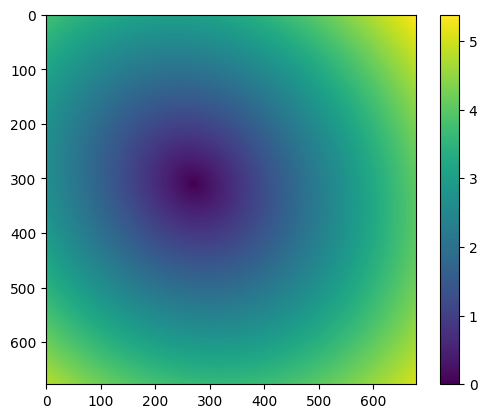

In [56]:

# specify the choice of lens models #
lens_model_list = ['SIE']

# setup lens model class with the list of lens models #
lensModel = LensModel(lens_model_list=lens_model_list)

# define parameter values of lens models #
theta_E = 100                 #in pixel
len_coord = (270, 310)        #in pixel
kwargs_sie = {'theta_E': theta_E, 'e1':0, 'e2':0.2, 'center_x': len_coord[0], 'center_y': len_coord[1]}
kwargs_lens = [kwargs_sie]

# image plane coordinate #
size = 678
pixscale = 0.01
x_grid, y_grid = np.meshgrid(np.linspace(0, size-1, size), np.linspace(0, size-1, size))

# Flatten the grid for calculations
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()

# Calculate convergence (kappa)
kappa = lensModel.kappa(x_flat, y_flat, kwargs_lens)

# Reshape back to 2D grid
#kappa_2d = kappa.reshape(x_grid.shape)

# ray-tracing to the source plane

alpha_x, alpha_y = lensModel.alpha(x_flat, y_flat, kwargs_lens)
# make beta_x and beta_y 2d

alpha_x_2d = alpha_x.reshape(x_grid.shape)
alpha_y_2d = alpha_y.reshape(x_grid.shape)
alpha_x_arcsec = alpha_x_2d * pixscale
alpha_y_arcsec = alpha_y_2d * pixscale

psi = lensModel.potential(x_flat, y_flat, kwargs_lens)
psi = psi.reshape(x_grid.shape)
psi_arcsec = psi * pixscale**2


plt.imshow(psi_arcsec)   #assume this is in arcsec
plt.colorbar()

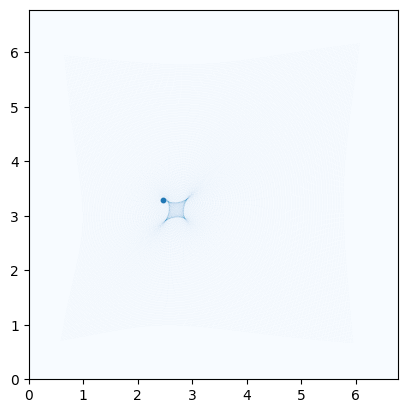

In [58]:
# illustrate the casutic
array_test = np.zeros([678,678])

for i in range(0, 678):
    for j in range(0, 678):
        ycoord = i-alpha_y_2d[i,j] # src coord
        xcoord = j-alpha_x_2d[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        xceil = ceil(xcoord)
        yceil = ceil(ycoord)
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        if i%3==0 and j%3==0:
            array_test[yfloor,xfloor] += 1 
      
    
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()
plt.scatter(2.47, 3.28, s =10)

In [59]:
x_grid = np.linspace(0, size-1, size)
x_grid = x_grid * pixscale

In [60]:
# Assuming deflection maps are stored in alpha_x_map and alpha_y_map
# and that they are on a grid defined by x_grid and y_grid

# Set up the interpolated lens model
lens_model_list = ['INTERPOL']
kwargs_lens = [{'grid_interp_x': x_grid, 'grid_interp_y': x_grid, 'f_': psi_arcsec,
                          'f_x': alpha_x_arcsec, 'f_y': alpha_y_arcsec}]

lens_model = LensModel(lens_model_list=lens_model_list)

# Define source position
beta_x, beta_y = 2.57, 3.28
# Use lens equation solver
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
solver = LensEquationSolver(lens_model)

# Solve for image positions
possible_solutions = solver.candidate_solutions(beta_x, beta_y, kwargs_lens,verbose= True)
print(possible_solutions)

# my code
z_s = 1.0
z_l = 0.5
cluster = ClusterLensing(alpha_x_arcsec, alpha_y_arcsec, psi_arcsec, z_l , z_s, pixscale, 678, diff_z = True)
theta = cluster.get_image_positions(beta_x, beta_y)
print(theta)

(array([2.65, 3.05, 3.35, 3.45, 3.55, 1.85]), array([2.25, 2.35, 2.55, 2.75, 2.95, 4.05]), array([0.04022872, 0.03678263, 0.03634095, 0.03540813, 0.03648901,
       0.00996466]), 0.09999999999999964)
[(1.8708361496914256, 4.068363301163309), (2.690287188372673, 2.2882709332630777)]


In [61]:
kwargs_mp = {'theta_E': theta_E* pixscale, 'e1':0, 'e2':0.2, 'center_x': len_coord[0]* pixscale, 'center_y': len_coord[1]* pixscale}
kwargs_lens1 = [kwargs_mp]
solver1 = LensEquationSolver(lensModel)
possible_solutions_analytical = solver1.candidate_solutions(beta_x, beta_y, kwargs_lens1,verbose= True)
print(possible_solutions_analytical)
possible_solutions_approx = cluster.find_rough_def_pix(beta_x/pixscale, beta_y/pixscale)
print(possible_solutions_approx)
real_solutions = solver1.image_position_from_source(beta_x, beta_y, kwargs_lens1)
print(real_solutions)

(array([2.65, 3.05, 3.35, 3.45, 3.55, 1.85]), array([2.25, 2.35, 2.55, 2.75, 2.95, 4.05]), array([0.04022872, 0.03678263, 0.03634095, 0.03540813, 0.03648901,
       0.00996466]), 0.09999999999999964)
[(267, 229), (268, 229), (269, 229), (270, 229), (271, 229), (186, 406), (187, 407)]
(array([1.87083742, 2.6902818 ]), array([4.0683678 , 2.28826896]))


In [63]:
real_sol_interpol = solver.image_position_from_source(beta_x, beta_y, kwargs_lens)
print(real_sol_interpol)

(array([1.87083615, 2.69028719]), array([4.0683633 , 2.28827093]))


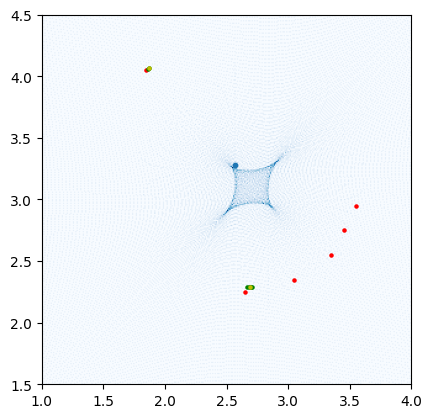

In [45]:
plt.imshow(array_test, cmap='Blues', extent=[0, 678* pixscale, 678* pixscale, 0])
plt.gca().invert_yaxis()
plt.xlim(1,4)
plt.ylim(1.5,4.5)
plt.scatter(beta_x, beta_y, s =10)
plt.scatter(possible_solutions_analytical[0], possible_solutions_analytical[1], s=5, c='r')
for i in range(0, len(possible_solutions_approx)):
    plt.scatter(possible_solutions_approx[i][0]*pixscale, possible_solutions_approx[i][1]*pixscale, s=5, c = 'g')
plt.scatter(real_solutions[0], real_solutions[1], s=5, c='y')